# Hierarchical Reasoning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from environments.gridworlds.gridworlds_classic import FourRoom
from environments.mutantworlds.mutantworlds_foster import FosterWorld
from agents.pgp.pgp_softmax import SoftMaxPGP
from agents.classics import Reinforce, DynaQ
from plots.gridworlds.gridworld_visualizer import GridWorldVisualizer
from plots.agent_plotter import AgentPlotter
from utils.policy_tools import *
from utils.policy_functions import *

np.set_printoptions(precision=2)

Create a simple grid world visualize it

In [3]:
size_room = 5
pR_offset = [2, 0]
p0_offset = [1, -1]

init_locs = np.array([[int(size_room/2 + 1), int(size_room/2 + 1)]]) + p0_offset
term_locs = np.array([[int(size_room*3/2 + 2), int(size_room*3/2 + 2)]]) + pR_offset

world = FourRoom(size_room, init_locs=init_locs, term_locs=term_locs)
gamma = 0.85

agent = SoftMaxPGP(world, gamma=gamma)
viz = GridWorldVisualizer(world, agent)
plotter = AgentPlotter(agents = [agent])


/home/fran-tr/Workspace/gpp_core/utils/policy_functions.py:43: RuntimeWarning: divide by zero encountered in log
  return np.log(agent.A / np.sum(agent.A, axis=1, keepdims=True))


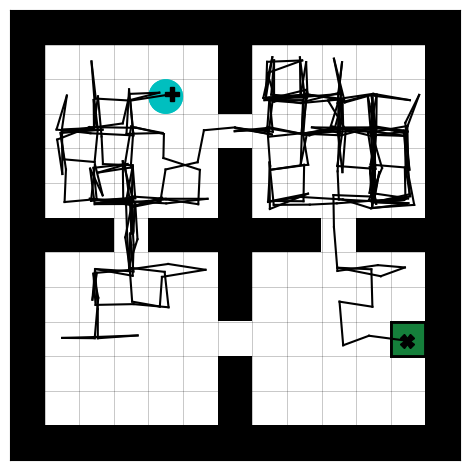

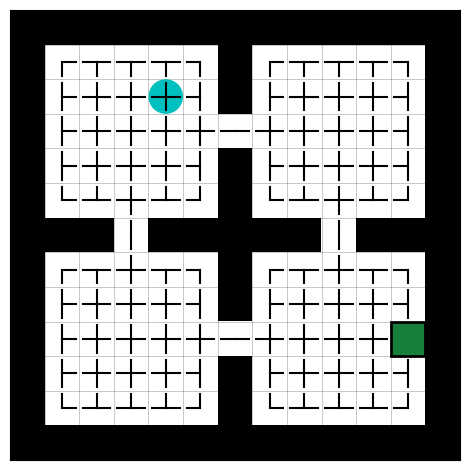

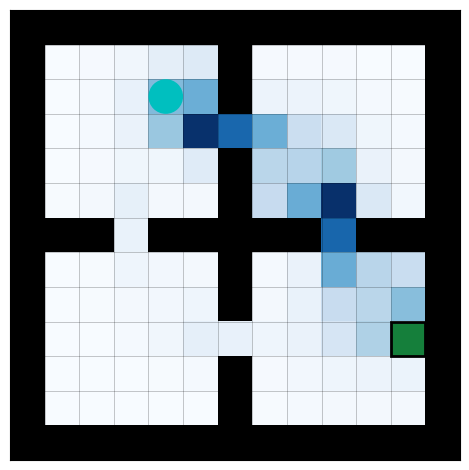

In [4]:
viz.plot_maze(plot_axis=False)
viz.plot_trajectory(plot_axis=False)
plt.tight_layout()
plt.show()

viz.plot_policy(plot_axis=False)
plt.tight_layout()
plt.show()

viz.plot_gradient_norm(plot_axis=False)
viz.plot_maze(plot_axis=False)
plt.tight_layout()
plt.show()

In [5]:
l1 = 1
l2 = size_room + 1
r1 = size_room + 2
r2 = size_room*2 + 2
    
states = np.ndarray([world.n_state - 4], dtype=int)
states_lab = []
states_col = []

i = 0
for x in range(l1, l2):
    for y in range(l1, l2):
        states[i] = world.encode(np.array([x, y]))
        states_lab.append("Room 1") 
        states_col.append("red")
        i += 1

for x in range(l1, l2):
    for y in range(r1, r2):
        states[i] = world.encode(np.array([x, y]))
        states_lab.append("Room 2")
        states_col.append("green")
        i += 1

for x in range(r1, r2):
    for y in range(l1, l2):
        states[i] = world.encode(np.array([x, y]))
        states_lab.append("Room 3")
        states_col.append("purple")
        i += 1


for x in range(r1, r2):
    for y in range(r1, r2):
        states[i] = world.encode(np.array([x, y]))
        states_lab.append("Room 4")
        states_col.append("blue")
        i += 1

plotter.set_states(states, state_labels=states_lab, state_colors=states_col)

In [6]:
# Training parameters
n_steps=2000
alpha_func=situational_alpha
alpha_options = {"situational": 0, "alpha_norm":None, "alpha_mean":0.01}
p_func = p0_onehot
grad_options={"λ":0}

# Training
agent.reset()
agent.learn(n_steps=n_steps, alpha_func=alpha_func, alpha_kwargs=alpha_options, p_s0_func=p_func, gradient_kwargs=grad_options)

100%|██████████| 2000/2000 [00:03<00:00, 553.64it/s]


### Analysis

In [7]:
ts = [1, 499, 1999]
cs = ["white", "grey", "black"]

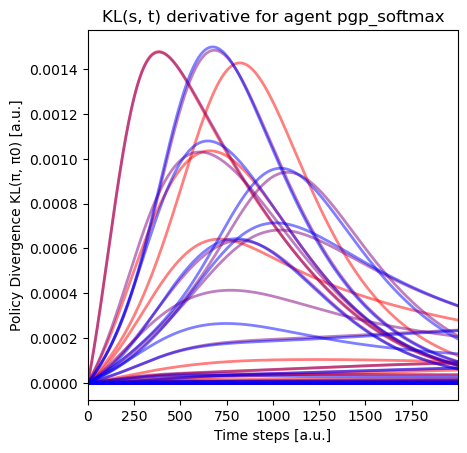

In [8]:
plotter.plotKLDivergence(agent, plot_legend=False, derivative=True, normalized=False)


/home/fran-tr/Workspace/gpp_core/plots/agent_plotter.py:200: RuntimeWarning: invalid value encountered in divide
  cd = cd / np.max(np.abs(cd), axis=0)


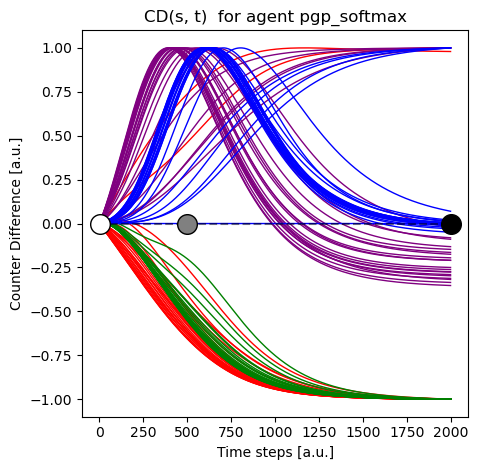

In [9]:
plotter.plotCounterDifference(agent, normalized=True, plot_legend=False)
plt.hlines(0, xmin=0, xmax=n_steps, colors="black", alpha=0.5, linestyles='--')
for t, c in zip(ts, cs):
    plt.scatter(t, 0, c=c, s=200, edgecolors="black", zorder=2)
plt.tight_layout()

In [10]:

states_cmap = np.zeros([world.n_state], dtype=int)
for s in range(world.n_state):
    l = world.decode(s)
    if l[0] <= l2 and l[1] < l2:
        states_cmap[s] = 1
    elif l[0] < l2 and l[1] >= l2:
        states_cmap[s] = 3
    elif l[0] > l2 and l[1] <= l2:
        states_cmap[s] = 4
    else:
        states_cmap[s] = 2
     

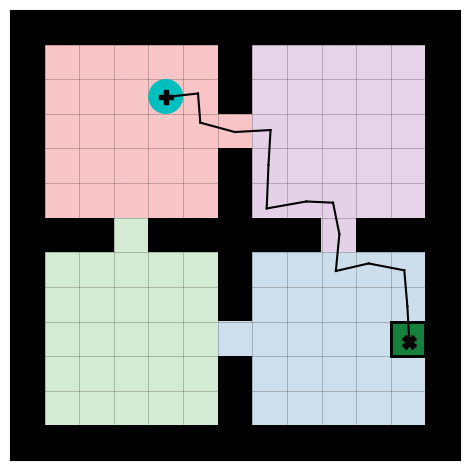

In [11]:
agent.gamma = 0.99
pcd = agent.p0 @ agent.SR


viz.plot_alpha_grid(states_cmap, pcd, plot_axis=False, cmap="Set1", vmin=0, vmax=10, hmin=0.25)
viz.plot_maze(plot_axis=False)
viz.plot_trajectory(greedy=True, plot_axis=False)
plt.tight_layout()

Compare With Reinforce

In [12]:
# reinf = Reinforce(world)
# qdyna = DynaQ(world)

# viz_r = GridWorldVisualizer(world, reinf)
# viz_q = GridWorldVisualizer(world, qdyna)

# t_r = 0

# for t, c in zip(ts, cs):
    
#     t_r = t - t_r
#     reinf.learn(n_episodes=t_r, alpha=0.001)
#     qdyna.learn(n_episodes=t_r, alpha=0.01)
#     agent.load_history_policy(t)

#     print("t step = {}".format(t))

#     viz.plot_trajectory_distribution(plot_maze=False, plot_grid=False, plot_axis=False)
#     viz.plot_policy(plot_axis=False)
#     plt.tight_layout()
#     plt.title("GPP Policy")
#     plt.show()

#     viz_r.plot_trajectory_distribution(plot_maze=False, plot_grid=False, plot_axis=False)
#     viz_r.plot_policy(plot_axis=False)
#     plt.tight_layout()
#     plt.title("RF Policy")
#     plt.show()

#     viz_q.plot_trajectory_distribution(plot_maze=False, plot_grid=False, plot_axis=False)
#     viz_q.plot_policy(plot_axis=False)
#     plt.tight_layout()
#     plt.title("QD Policy")
#     plt.show()


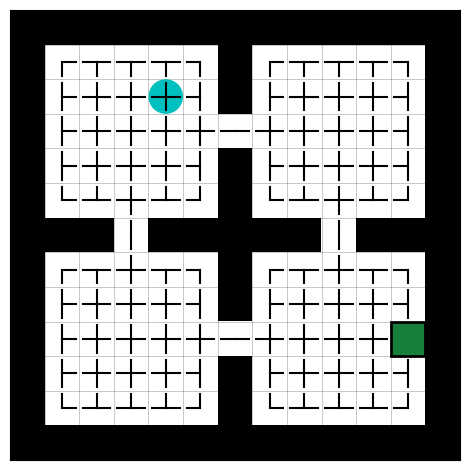

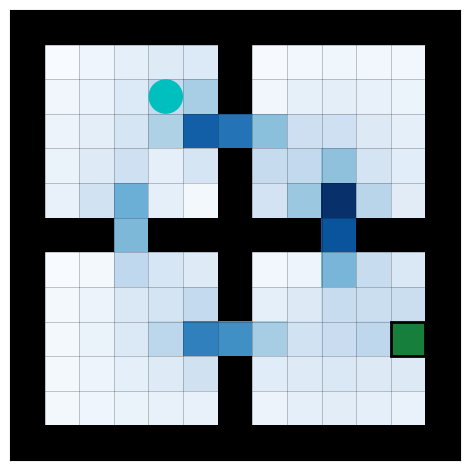

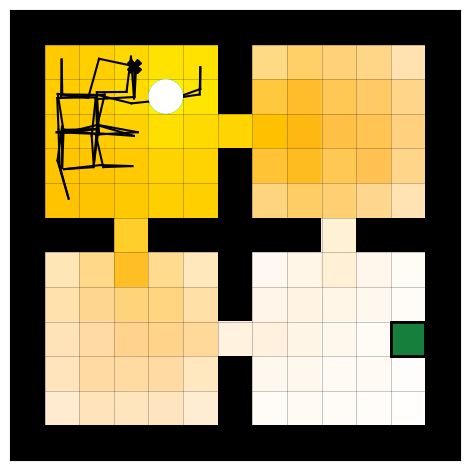

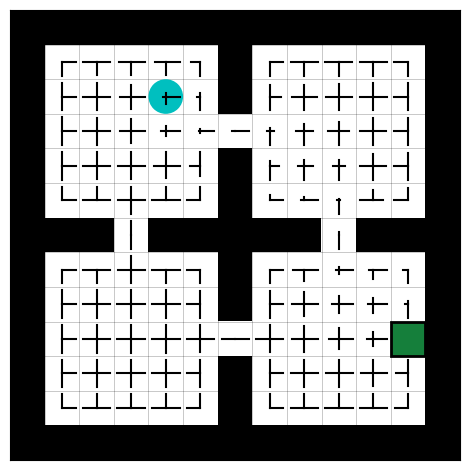

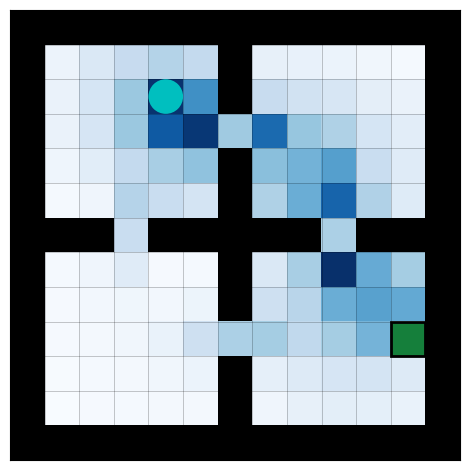

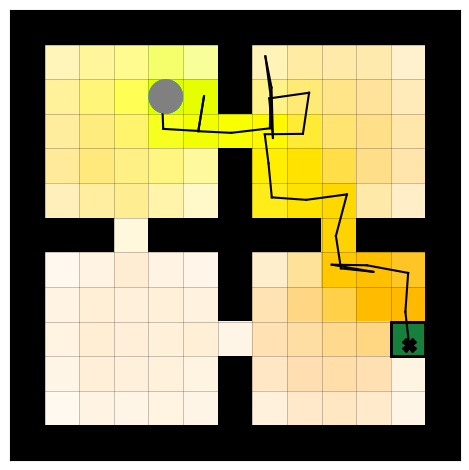

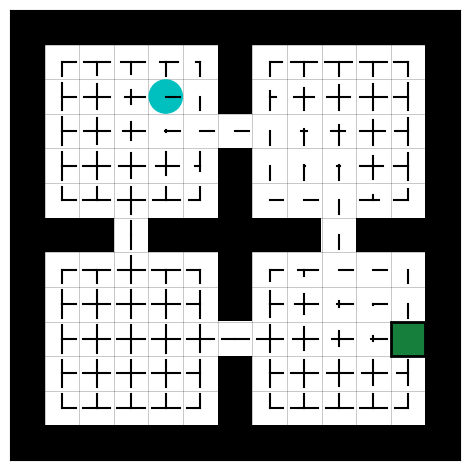

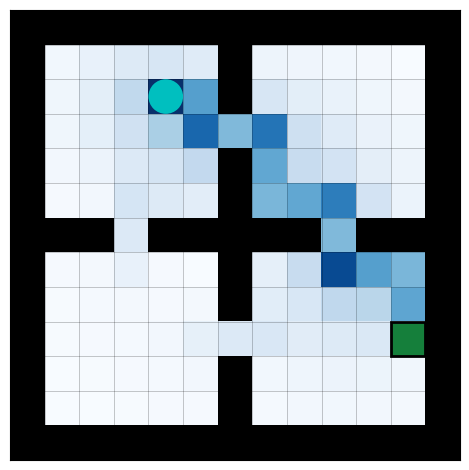

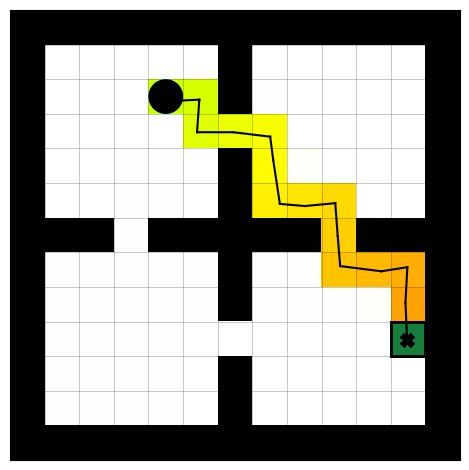

In [13]:
for t, c in zip(ts, cs):
    
    agent.load_history_policy(t)

    viz.plot_policy(plot_axis=False)
    plt.tight_layout()
    plt.show()

    viz.plot_gradient_norm(plot_axis=False)
    viz.plot_maze(plot_axis=False)
    plt.tight_layout()
    plt.show()

    viz.plot_trajectory_distribution(plot_axis=False, min_hue=0.2, max_hue=0.1, n_samples=1000, n_steps=100)
    viz.plot_trajectory(plot_axis=False, n_steps=50)
    viz.plot_states(world.states_start, colors=[c])
    plt.tight_layout()
    plt.show()


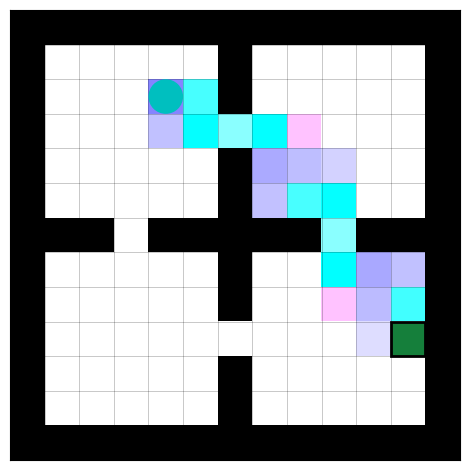

In [14]:
values1, ranks1, times1, hist1, _, _ = rank_states(agent=agent, f=policy_divergence, n_histo_bins=3, value_min=0.1)

viz.plot_alpha_grid(hist1, values1, plot_axis=False, cmap="cool", alpha_threshold=0.1)
viz.plot_maze(plot_axis=False)
plt.tight_layout()

# Situational Reasoning

In [15]:
world2 = FourRoom(size_room)
agent2 = SoftMaxPGP(world, gamma=gamma)
viz2 = GridWorldVisualizer(world2, agent2)

In [16]:
red_door = world.encode(np.array([6, 3]))
purple_door = world.encode(np.array([9, 6]))
green_door = world.encode(np.array([3, 6]))
blue_door = world.encode(np.array([6, 9]))

doors_s = [red_door, purple_door, green_door, blue_door]
doors_l = ["red door", "purple door", "green door", "blue door"]
doors_c = ["red", "purple", "green", "blue"]

In [17]:
plotter2 = AgentPlotter(agents = [agent2])
plotter2.set_states(states=states, state_labels=states_lab, state_colors=states_col)

100%|██████████| 2000/2000 [00:03<00:00, 567.75it/s]


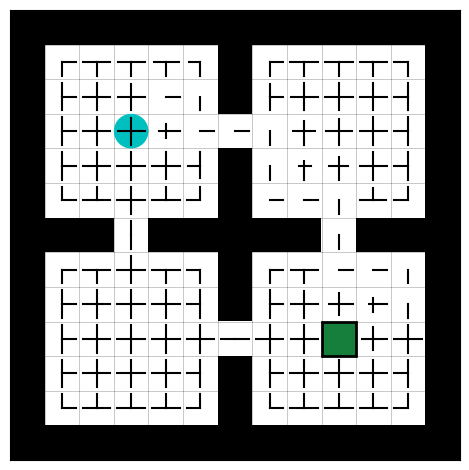

In [18]:
# Training parameters
alpha_options2 = {"situational": 1, "alpha_norm":None, "alpha_mean":0.01}

# Training
agent2.reset()
agent2.learn(n_steps=n_steps, alpha_func=alpha_func, alpha_kwargs=alpha_options2, p_s0_func=p_func, gradient_kwargs=grad_options)

viz2.plot_policy(plot_axis=False)
plt.tight_layout()

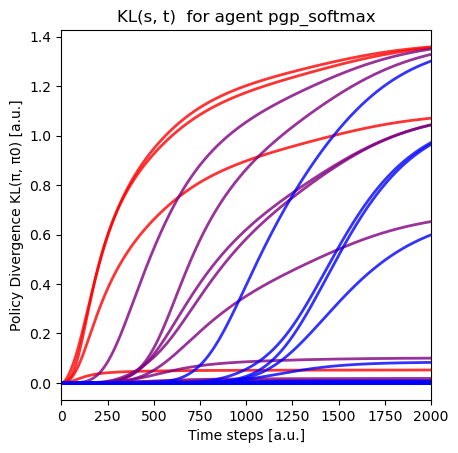

In [19]:
plotter2.plotKLDivergence(0, derivative=False, normalized=False, plot_legend=False, alpha=0.8)

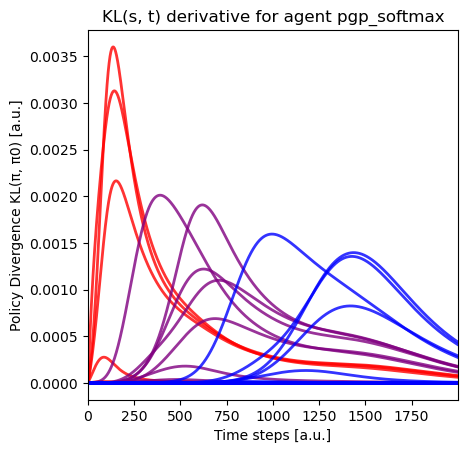

In [20]:
plotter2.plotKLDivergence(0, derivative=True, normalized=False, plot_legend=False, alpha=0.8)

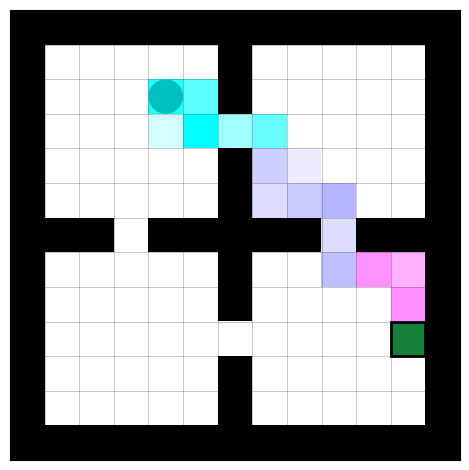

In [21]:
values2, ranks2, times2, hist2, _, _ = rank_states(agent=agent2, f=policy_divergence, n_histo_bins=3, value_min=0.05)

viz.plot_alpha_grid(hist2, values2, plot_axis=False, cmap="cool", alpha_threshold=0.05)
viz.plot_maze(plot_axis=False)
plt.tight_layout()

# Replays

In [22]:
# objects
maze = FosterWorld(goal_reward=100, doors_cost=-100, pillars_as_cost=False, small_version=False)
gpp = SoftMaxPGP(maze, gamma=0.99, p0_func=(lambda agent, s0s, p0s: p0_situational(agent, s0s, p0s, situational=0.995)))
viz = GridWorldVisualizer(maze, gpp)

In [23]:
# training parameters
replay_steps = 4000
replay_alpha_kwargs = {'situational':0.95, 'alpha_norm':None, 'alpha_mean':0.2}
replay_grad_kwargs={"λ":0}
replay_kld_threshold = 0.05

Foster's Maze #2


100%|██████████| 4000/4000 [00:15<00:00, 264.40it/s]


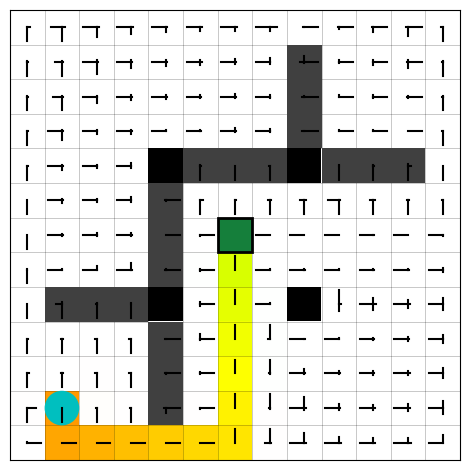

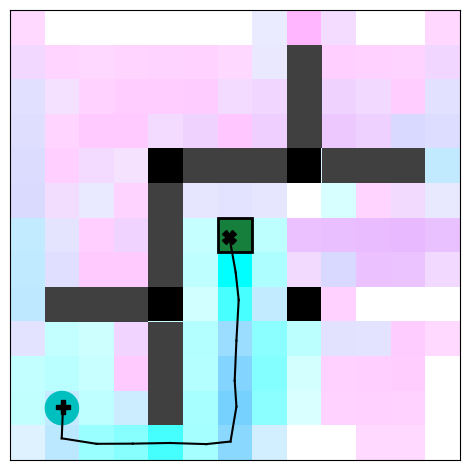

Foster's Maze #3


100%|██████████| 4000/4000 [00:15<00:00, 264.92it/s]


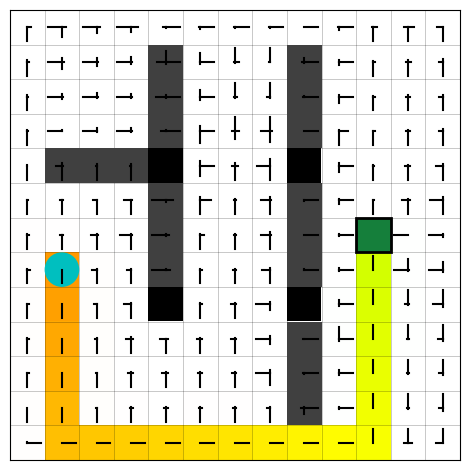

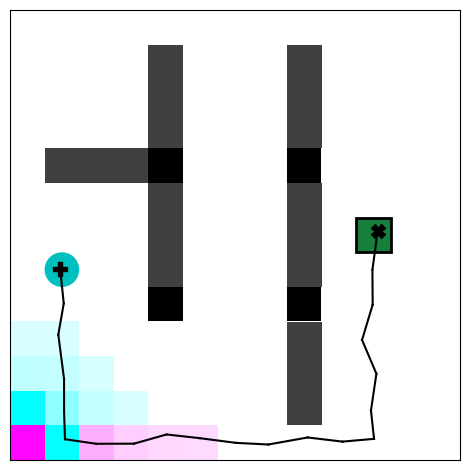

Foster's Maze #4


100%|██████████| 4000/4000 [00:15<00:00, 264.67it/s]


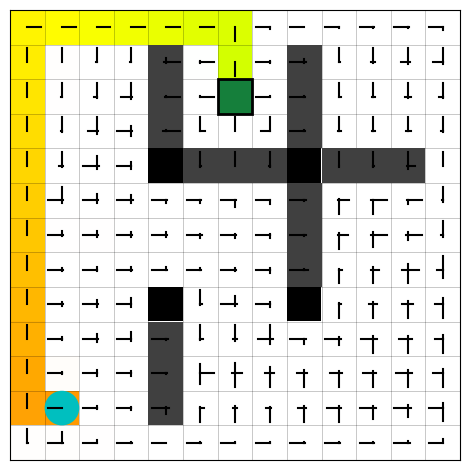

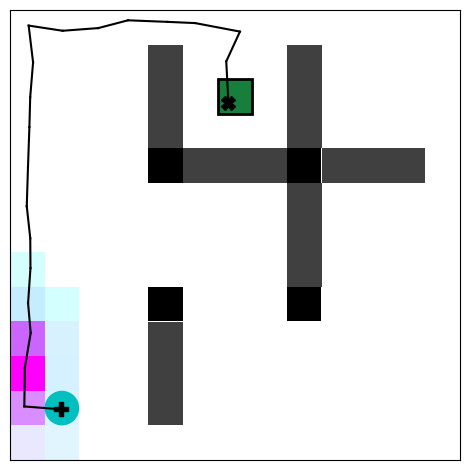

Foster's Maze #5


100%|██████████| 4000/4000 [00:14<00:00, 270.96it/s]


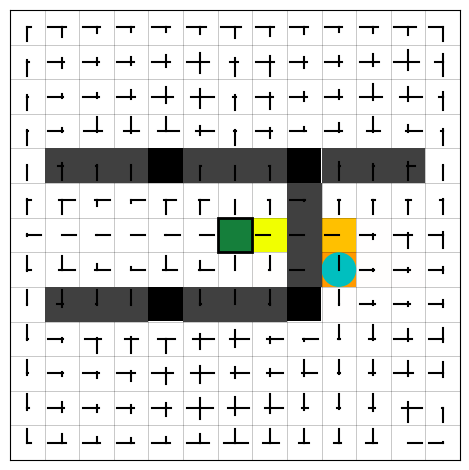

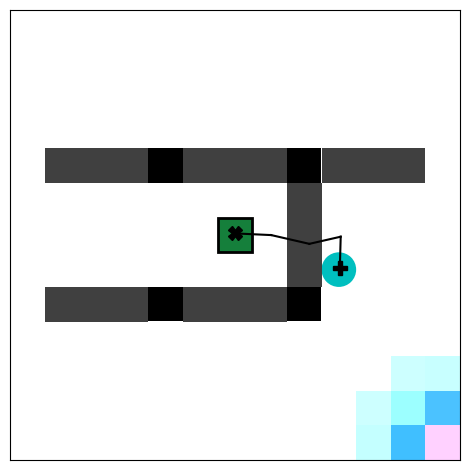

Foster's Maze #6


100%|██████████| 4000/4000 [00:14<00:00, 271.28it/s]


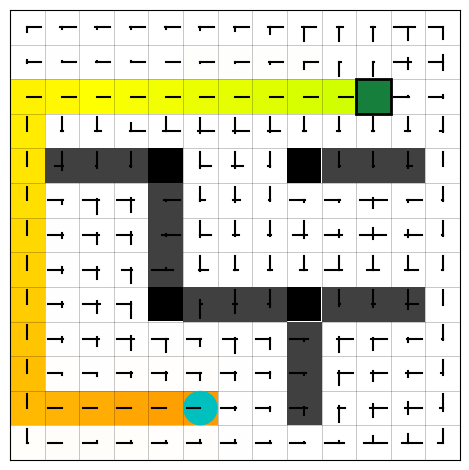

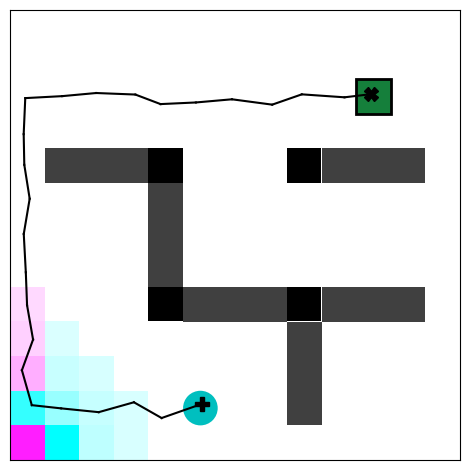

Foster's Maze #7


100%|██████████| 4000/4000 [00:14<00:00, 272.54it/s]


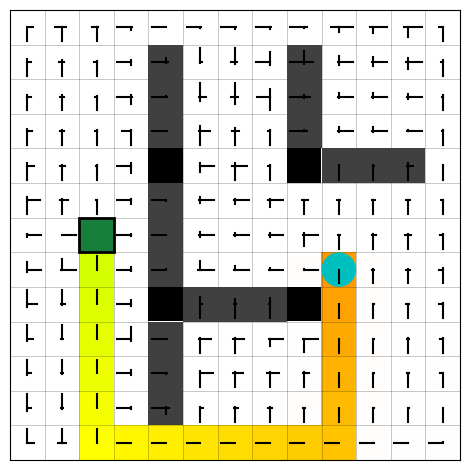

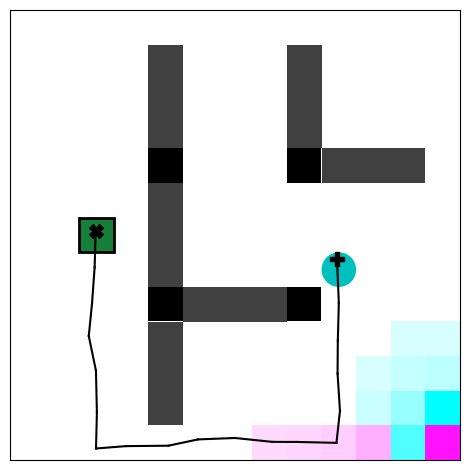

Foster's Maze #8


100%|██████████| 4000/4000 [00:14<00:00, 272.09it/s]


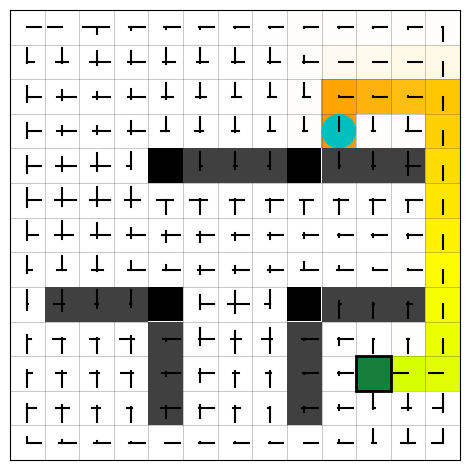

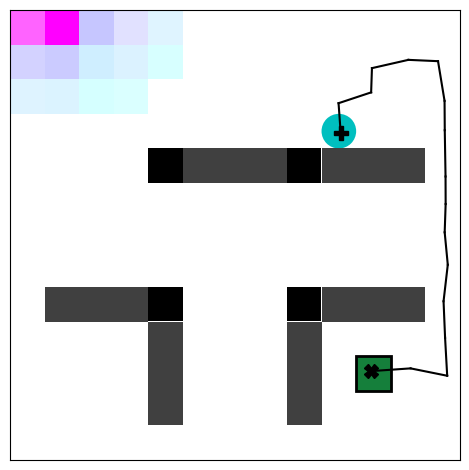

Foster's Maze #9


 68%|██████▊   | 2710/4000 [00:10<00:05, 248.54it/s]


KeyboardInterrupt: 

In [24]:
for i_m in range(1, maze.n_mutations):
    
    # change the configuration of the maze
    maze.mutate(i_m)

    # Reset the policy and the starting position
    gpp.reset()
   
    # Training
    print("Foster's Maze #{}".format(i_m+1))
    gpp.learn(n_steps=replay_steps, alpha_func=situational_alpha, gradient_kwargs=replay_grad_kwargs, alpha_kwargs=replay_alpha_kwargs)
    values, ranks, times, hist, mask, time_max = rank_states(gpp, f=policy_divergence, value_min=replay_kld_threshold)

    # Plot
    viz.plot_trajectory_distribution(plot_maze=False, plot_axis=False, min_hue=0.1, max_hue=0.2)
    viz.plot_maze(plot_grid=False, plot_axis=False, neg_rew_cmap="Greys")
    viz.plot_policy(plot_maze=False, plot_grid=False, plot_axis=False)
    plt.tight_layout()
    plt.show()
    
    viz.plot_alpha_grid(hist, values, mask=mask, plot_axis=False, plot_grid=False, cmap="cool")
    viz.plot_maze(plot_grid=False, plot_axis=False, neg_rew_cmap="Greys")
    # viz.plot_trajectory(ss=replay_trajectory, plot_maze=False, plot_grid=False, plot_axis=False)
    viz.plot_trajectory(plot_maze=False, plot_grid=False, plot_axis=False)
    plt.tight_layout()
    plt.show()

In [ ]:
print("color bars")
im = plt.imshow(np.array([[0,0,1,1,2,2]]), cmap="cool")
plt.show()
im = plt.imshow(np.array([[0,1,2,3,4]]), cmap="cool")
plt.show()

### SR sampling

In [ ]:
from tqdm import tqdm

def sampleSR(agent, n_rollouts=1000, n_steps=1000, viz=None):

    ASR = np.zeros([agent.n_state])

    error = np.zeros([n_rollouts])
    for r in tqdm(range(n_rollouts)):
        s0 = agent.state
        ss, _, _, __ = agent.trajectory(s0=s0, n_steps=n_steps, greedy=False, move=False)
         
        weight = 1
        for s in ss:
            ASR[s] += weight
            weight = weight * agent.gamma

        if viz is not None:
            vmax = max(np.max(agent.SR), np.max(ASR))
            plt.subplot(1,2,1)
            viz.plot_grid(vec=agent.SR[s0, :], vmin=0, vmax=vmax)

            plt.subplot(1,2,2)
            viz.plot_grid(vec=ASR, vmin=0, vmax=vmax)
            plt.tight_layout()

            plt.show()
            plt.pause(0.5)

        ASR_plot = ASR
        ASR_plot[*agent.env.states_terminal] = 0
        # ASR_plot[*agent.env.states_start] = 0
        ASR_plot = ASR_plot - np.min(ASR_plot)
        ASR_plot = ASR_plot / np.max(ASR_plot)

        SR = agent.SR[agent.state]
        SR[*agent.env.states_terminal] = 0
        # SR[*agent.env.states_start] = 0
        SR = SR - np.min(SR)
        SR = SR / np.max(SR)

        error[r] = np.linalg.norm(ASR_plot - SR)

    ASR = ASR / n_rollouts
    return ASR, error


In [ ]:
nxs = [2, 5, 8]
colors = ["green", "blue", "red"]

ee = []
for nx in nxs:

    print("rooms with size = {}...".format(nx))

    m = FourRoom(n_square=nx)
    a = SoftMaxPGP(env=m, gamma=0.95)
    v = None
    
    ASR, e_start = sampleSR(a, n_rollouts=1000, n_steps=1000, viz=v)

    agent.learn(n_steps=1000)
    ASR, e_end = sampleSR(a, n_rollouts=1000, n_steps=1000, viz=v)

    ee.append([e_start, e_end])

In [ ]:
%matplotlib qt 

for nx, c, e in zip(nxs, colors, ee):
    
    e_start = e[0]
    e_end = e[1]

    plt.plot(e_start, label="s={}, t=0".format(nx*nx*4), color=c, linestyle="--")
    plt.plot(e_end, label="s={}, t=1000".format(nx*nx*4), color=c, linestyle="-")
plt.legend()
plt.show()
